In [ ]:
!pip install nbimporter

In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import torch.nn.init as init
from torch.autograd import Variable
from dataLoader import loadData
from tensorflow import keras

In [2]:
# # Downloading Movielens-1m
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip
# #     http://www.grouplens.org/system/files/ml-1m.zip
# !unzip ml-1m.zip
# !cd ml-1m/

In [3]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [4]:
seed = 47
np.random.seed(seed)

In [5]:
# load data
tr, vr = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed, transpose=False, valfrac=0.1)

reading data...
data read in 5.629438877105713 seconds
loaded dense data matrix


In [6]:
np.save('./tr_movielens_1m', tr)
np.save('./vr_movielens_1m', vr)

In [7]:
tr

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
vr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [10]:
get_sparsity(tr)

4.021525859265269

In [11]:
get_sparsity(vr)

0.44683670296601535

In [12]:
train = tr.copy()

In [13]:
if torch.cuda.is_available() == True:
    device = "cuda"
else:
    device = "cpu"

# Training Denoising Autoencoder

In [14]:
############## Pytorch model doesn't converge - to do - check #################

from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1', kernel_regularizer=regularizers.l2(0.000001))(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(512, activation='selu', name='LatentSpace', kernel_regularizer=regularizers.l2(0.000001))(enc)
    lat_space = Dropout(0.5, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1', kernel_regularizer=regularizers.l2(0.000001))(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred', kernel_regularizer=regularizers.l2(0.000001))(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

Using TensorFlow backend.


In [15]:
zero_mask = (train == 0)
positive_feedback_mask = (train > 3)
negative_feedback_mask = ((train < 4) * (1 - zero_mask))

In [16]:
assert (positive_feedback_mask + negative_feedback_mask != zero_mask).all()
assert (positive_feedback_mask + negative_feedback_mask == 1 - zero_mask).all()

In [17]:
get_sparsity(zero_mask), get_sparsity(positive_feedback_mask), get_sparsity(negative_feedback_mask)

(95.97847414073473, 2.3124349989099473, 1.7090908603553212)

In [18]:
100 - get_sparsity(zero_mask), get_sparsity(positive_feedback_mask), get_sparsity(negative_feedback_mask), get_sparsity(positive_feedback_mask) + get_sparsity(negative_feedback_mask)

(4.021525859265267, 2.3124349989099473, 1.7090908603553212, 4.021525859265268)

In [19]:
P = 0.4
mask_arr_neg = (np.random.rand(negative_feedback_mask.shape[0], negative_feedback_mask.shape[1]) > P)
y_neg = negative_feedback_mask
X_neg = negative_feedback_mask*mask_arr_neg # corrupting 

In [20]:
mask_arr_pos = (np.random.rand(positive_feedback_mask.shape[0], positive_feedback_mask.shape[1]) > P)
y_pos = positive_feedback_mask
X_pos = positive_feedback_mask*mask_arr_pos # corrupting 

In [21]:
get_sparsity(X_neg), get_sparsity(y_neg), get_sparsity(X_pos), get_sparsity(y_pos)

(1.026195215919772, 1.7090908603553212, 1.3870741200058612, 2.3124349989099473)

In [22]:
model_neg = autoEncoder(X_neg)
model_neg.compile(optimizer = Adam(lr=0.0001), loss='mse')

model_pos = autoEncoder(X_pos)
model_pos.compile(optimizer = Adam(lr=0.0001), loss='mse')

In [23]:
model_neg = keras.models.load_model('./model_neg')
model_pos = keras.models.load_model('./model_pos')

In [24]:
model_neg.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserScore (InputLayer)       [(None, 3706)]            0         
_________________________________________________________________
EncLayer1 (Dense)            (None, 512)               1897984   
_________________________________________________________________
LatentSpace (Dense)          (None, 512)               262656    
_________________________________________________________________
Dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
DecLayer1 (Dense)            (None, 512)               262656    
_________________________________________________________________
UserScorePred (Dense)        (None, 3706)              1901178   
Total params: 4,324,474
Trainable params: 4,324,474
Non-trainable params: 0
_________________________________________________

In [ ]:
# predicted_tr = np.load('predicted_tr.npy')
# augmented_train = np.load('augmented_train.npy')

In [ ]:
hist_neg = model_neg.fit(x=X_neg, y=y_neg,
                  epochs=300,
                  batch_size=128,
                  shuffle=True,
# augmented_train = np.load('augmented_train.npy')
                  validation_split=0.0)

In [ ]:
hist_pos = model_pos.fit(x=X_pos, y=y_pos,
                  epochs=300,
                  batch_size=128,
                  shuffle=True,
                  validation_split=0.0)

In [ ]:
import matplotlib.pyplot as plt 

def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    #plt.plot(hist.history['val_loss'])

In [ ]:
plot_hist(hist_neg)

In [ ]:
plot_hist(hist_pos)

In [ ]:
model_neg.save('./model_neg')
model_pos.save('./model_pos')

In [25]:
np.set_printoptions(precision=3)
predicted_neg = model_neg.predict(X_neg)
predicted_pos = model_pos.predict(X_pos)

In [26]:
(predicted_neg > 0.4).sum(), (y_neg == 1).sum() # predicted vs real

(170143, 382567)

In [27]:
(predicted_neg>0.5).sum(), (predicted_pos>0.5).sum() # trained on

(115775, 214496)

In [28]:
print((y_neg * (predicted_neg>0.4)).sum()/(predicted_neg>0.4).sum()) # accuracy on actual 
print((y_pos * (predicted_pos>0.4)).sum()/(predicted_pos>0.4).sum())

0.9528337927508037
0.9187441580985445


In [29]:
print((y_pos * (predicted_neg>0.4)).sum()/(y_pos>0.4).sum()) # just to see that it's a low number
print((y_neg * (predicted_pos>0.4)).sum()/(y_neg>0.4).sum())

0.004936043939484681
0.016499070751005707


In [30]:
(y_neg * (predicted_neg>0.5)).sum()/((predicted_neg>0.5).sum())

0.9862405527963722

In [31]:
(y_pos * (predicted_pos>0.5)).sum()/((predicted_pos>0.5).sum())

0.9698642398925854

In [32]:
((predicted_neg>0.5)  * (X_neg<0.5)).sum() # predicted values which were not in the train matrix

39637

In [33]:
((predicted_pos>0.5)  * (X_pos<0.5)).sum() # predicted values which were not in the train matrix

69892

In [34]:
((y_neg * (((predicted_neg>0.5)  * (X_neg<0.5)))) == 1).sum()/(((predicted_neg>0.5)  * (X_neg<0.5))).sum()

0.9598102782753488

In [35]:
((y_pos * (((predicted_pos>0.5)  * (X_pos<0.5)))) == 1).sum()/(((predicted_pos>0.5)  * (X_pos<0.5))).sum()

0.9075144508670521

In [36]:
to_add_negative = model_neg.predict(y_neg)
to_add_positive = model_neg.predict(y_pos)

In [37]:
(to_add_negative>0.5).sum(), (to_add_positive>0.5).sum()

(207742, 234140)

In [38]:
(y_neg* (to_add_negative>0.8)).sum()/(((to_add_negative>0.8)).sum()), (y_pos* (to_add_positive>0.8)).sum()/(((to_add_positive>0.8)).sum())

(0.9874735206891682, 0.9078462031914041)

In [39]:
# to keep the balance
threshold_neg = 0.2
threshold_pos = 0.3 

In [40]:
((to_add_negative > threshold_neg) * (tr==0)).sum(), ((to_add_positive > threshold_pos) * (tr==0)).sum() # new values # new values

(345157, 240626)

In [41]:
p_probs_neg = [(tr == 1).sum()/((tr > 0) & (tr < 4)).sum(), (tr == 2).sum()/(((tr > 0) & (tr < 4))).sum(), (tr == 3).sum()/((tr > 0) & (tr < 4)).sum()]
p_probs_neg

[0.13207882540835983, 0.25313474502505445, 0.6147864295665857]

In [42]:
p_probs_pos = [(tr == 4).sum()/((tr > 3) & (tr <= 5)).sum(), (tr == 5).sum()/((tr > 3) & (tr <= 5)).sum()]
p_probs_pos

[0.6064147320143503, 0.39358526798564974]

In [43]:
augmented_train = tr + (to_add_negative > threshold_neg) * (tr == 0) * np.random.choice(np.arange(1, 4), tr.shape, p=p_probs_neg) + (to_add_positive > threshold_pos) * (tr == 0) * np.random.choice(np.arange(4, 6), tr.shape, p=p_probs_pos)

In [44]:
get_sparsity(tr), get_sparsity(augmented_train) # reduced sparsity

(4.021525859265269, 6.412851184583439)

In [45]:
(np.isin(tr, augmented_train)).all()

True

In [46]:
print(5, (5 == tr).sum())
print(4, (4 == tr).sum())
print(3, (3 == tr).sum())
print(2, (2 == tr).sum())
print(1, (1 == tr).sum())
print(0, (0 == tr).sum())

5 203728
4 313893
3 235197
2 96841
1 50529
0 21484052


In [47]:
print(5, (5 == augmented_train).sum())
print(4, (4 == augmented_train).sum())
print(3, (3 == augmented_train).sum())
print(2, (2 == augmented_train).sum())
print(1, (1 == augmented_train).sum())
print(0, (0 == augmented_train).sum())

5 282704
4 429003
3 416147
2 171461
1 89613
0 20948772


In [48]:
((tr == 0) * (augmented_train > 0)).sum() # new values

535280

In [49]:
# np.save('predicted_tr', predicted_tr)
np.save('augmented_train', augmented_train)

In [50]:
features_length = train.shape[1]
class NetD(torch.nn.Module):
    def __init__(self, feat_size):
        super(NetD, self).__init__()
        self.feat_size = feat_size
#         self.use_cuda = True
#         self.feat_size = feat_size
        # top
#         print(self.feat_size*2)
        self.t1 = torch.nn.Linear(self.feat_size, 1024)
        # bottom
        self.b1 = torch.nn.Linear(self.feat_size, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, self.feat_size)
    def forward(self, xr, xf):
        # get filt
        
        filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
#         if self.use_cuda: 
        idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = F.tanh(self.fc(x))
        # apply filter, aggregate
        x = filt * x
        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
        return x


class NetG(nn.Module):
    
    def __init__(self, feat_size):

        super(NetG, self).__init__()
        self.feat_size = feat_size
        self.netGen = torch.nn.Sequential( 
                                torch.nn.Linear(nz + self.feat_size, 1024), 
#                                 torch.nn.BatchNorm1d(1024),
                                torch.nn.ReLU(), 
#                                 nn.Dropout(0.5),
#                                 torch.nn.Linear(1024, 1024),
# #                                 torch.nn.BatchNorm1d(1024),
#                                 torch.nn.ReLU(), 
#                                 nn.Dropout(0.6),
                                torch.nn.Linear(1024, features_length), 
                                torch.nn.Sigmoid()
#                                 torch.nn.BatchNorm1d(features_length),
#                                 nn.Dropout(0.7),
#                                 torch.nn.Sigmoid()
                                )

        
    def forward(self, e_mask, x):
        x = self.netGen(x)
        x = x * e_mask
        return x
#         return F.dropout(x, 0.7)
#         return 5 * self.netGen(x)
#         return torch.sigmoid(x) 
#         return x*5 # to get values in range [0,5]

In [51]:
def get_random_batch(mat, batch_size=64):
    '''
    returns random rows of size batch_size
    '''
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(mat.shape, rand_rows)
#     print(mat[rand_rows].shape)
    return mat[rand_rows]

In [ ]:
train = torch.autograd.Variable(torch.Tensor(train))
augmented_train = torch.autograd.Variable(torch.Tensor(augmented_train))

In [ ]:
get_sparsity(train.cpu().numpy()), get_sparsity(augmented_train.cpu().numpy())

In [ ]:
# xx = get_random_batch(train)
# xy = get_random_batch(train)

In [ ]:
# d_my(xx, xy)

In [ ]:
# torch.sum(torch.abs(torch.abs(xx != 0).float()*xy - xy), 1)

In [ ]:
# xx > xy

In [ ]:
# # def d_my(x_r, x_g): # custom loss -todo
# #     return torch.sum(torch.abs((x_r != 0).float() * x_g - x_r), 1)/x_r.shape[1]

# def d_my(x_r, x_g): # custom loss -todo
#     return torch.sum(torch.abs(x_g - x_r), 1)/x_r.shape[1]

In [52]:
def batch_generator(corrupted, original, batch_size=64):
    rand_rows = np.random.randint(corrupted.shape[0], size=batch_size)
    return torch.Tensor(corrupted[rand_rows]).cuda().float(), torch.Tensor(original[rand_rows]).cuda().float()
#     return torch.from_numpy(corrupted[rand_rows]).float(), torch.from_numpy(original[rand_rows]).float()

In [53]:
get_sparsity(X_neg), get_sparsity(y_neg)

(1.026195215919772, 1.7090908603553212)

In [55]:
a,b = batch_generator(X_neg, y_neg)

# get_sparsity(a.numpy()), get_sparsity(b.numpy()), a.shape, b.shape

In [244]:
gen_losses = []
disc_losses = []
def train_GAN(netD, netG, negative, steps_per_epoch = 100, epochs = 100):
    d_iter = 5
    g_iter = 1
    gen_iterations = 0
#     gen_losses = []
#     disc_losses = []
#     train_losses = []
    for epoch in range(epochs):
        for c in range(steps_per_epoch):
            data_iter = 100
            i = 0
            while i < 100:
                ############################
                # (1) Update D network
                ###########################
                for p in netD.parameters(): # reset requires_grad
                    p.requires_grad = True # they are set to False below in netG update
    #             d_iter = d_iter
                j = 0
                while j < d_iter*5:
                    j += 1
                    # load real data
                    i += 1
                    if negative:
                        condition, X = batch_generator(X_neg, y_neg)
    #                 X, _ = data_iter.next()
    #                 X = X.view(X.size(0), -1)
    #                 X = (X >= 0.5).float()
                    if cuda: 
                        X = X.cuda()
                        condition = condition.cuda()
    #                 print(condition.shape, X_neg.shape, y_neg.shape)
                    real = Variable(X)

                    # generate fake data
                    noise = torch.randn(batch_size, nz)
                    if cuda: 
                        noise = noise.cuda()
                    noisev = Variable(noise, volatile = True) # totally freeze netG
                    concated = torch.cat((noisev, condition), 1)
    #                 print(condition.shape, condition.shape, X.shape, noisev.shape, )
                    e_mask = (real == 1).float()
                    fake = Variable(netG(e_mask, concated).data)

                    # compute gradient, take step
                    netD.zero_grad()
    #                 concated_real = torch.cat((real, condition), 1)
    #                 print(concated_real)
                    out = netD(real, fake)
                    outputD = torch.mean(out) + lamba * out.norm()
                    stdD = torch.std(out)
                    outputD.backward(mone)
                    optimizerD.step()
#                     print('AAAAAAAAA mse:=WWWWWWWWWWWWWWWWWWWWWW')
            ############################
            # (2) Update G network
            ###########################

    #         g_iter = g_iter
            j = 0
            while j < g_iter*5:
                j += 1
                for p in netD.parameters():
                    p.requires_grad = False # to avoid computation
                netG.zero_grad()
                # load real data

                i += 1
        #         X, _ = data_iter.next()
        #         X = X.view(X.size(0), -1)
        #         X = (X >= 0.5).float()
                if negative:
                    condition, X = batch_generator(X_neg, y_neg)
    #             if cuda: 
                X = X.cuda()
                condition = condition.cuda()
                real = Variable(X)

                # update generator
                noise = torch.randn(batch_size, nz)
    #             if args.cuda: 
                noise = noise.cuda()
                noisev = Variable(noise)
    #             print(condition.shape, X_neg.shape, y_neg.shape, noisev.shape)
                concated_ = torch.cat((noisev, condition), 1)
    #                 print(condition.shape, condition.shape, X.shape, noisev.shape, )
    #             e_mask = Variable((real == 1)).float()
    #             e_mask.requires_grad = True
    #             fake = Variable(netG(concated, X).data)
                e_mask_ = real.clone()
    #             concated_.requires_grad = True
    #             e_mask_.requires_grad = True
#                 real.requires_grad = True
#                 fake.requires_grad = True
#                 fake = Variable(netG(e_mask_, concated_).data)
    #             print((fake > 0).float().sum() == real.float().sum())
    #             print(fake)
    #             print(real)
    #             fake = netG(concated)
    #             concated_real = torch.cat((real, condition), 1)
                fake = netG(e_mask_, concated_)
                out = netD(real, fake)
                outputG = torch.mean(out) + lamba * out.norm()
                stdG = torch.std(out)
                outputG.backward(one)
                optimizerG.step()
                gen_iterations += 1
#             print('AAAAAA')
            eval_loss = F.mse_loss(fake, real, reduction='mean')
#             eval_losses.append(eval_loss)
#             print('mse:', eval_loss)
#             print(outputG.item(), outputD.item())
            gen_losses.append(outputG.item())
            disc_losses.append(outputD.item())
            print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, 100, gen_iterations, outputD.item(), outputG.item()))
    return gen_losses, disc_losses

In [245]:
get_sparsity(X_neg), get_sparsity(y_neg)

(1.026195215919772, 1.7090908603553212)

In [246]:
# lrD = 5e-4
# lrG = 5e-4
# batch_size = 128
# cuda = True
# epochs = 1000 #change
# seed = 1
# nz = 16
# d_iter = 5
# g_iter = 1
# lamba = 2e-4

lrD = 5e-4
lrG = 5e-4
batch_size = 64
cuda = True
epochs = 100
device = 5
seed = 1
nz = 10
lamba = 1e-4 
# lamba = 0

In [247]:
negative_feedback_mask.shape[1]

3706

In [248]:
# networks
netD_neg = NetD(negative_feedback_mask.shape[1]).cuda()
netG_neg = NetG(negative_feedback_mask.shape[1]).cuda()
print(netD_neg)
print(netG_neg)
optimizerG = optim.Adam(netG_neg.parameters(), lr=lrG)
optimizerD = optim.Adam(netD_neg.parameters(), lr=lrD)
one = torch.FloatTensor([1]).cuda()
mone = (-1 * one).cuda()

NetD(
  (t1): Linear(in_features=3706, out_features=1024, bias=True)
  (b1): Linear(in_features=3706, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3706, bias=True)
)
NetG(
  (netGen): Sequential(
    (0): Linear(in_features=3716, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=3706, bias=True)
    (3): Sigmoid()
  )
)


In [249]:
netD_neg.train()
netG_neg.train()
# gen_losses, disc_losses = train_GAN(netD_neg, netG_neg, negative=True)
train_GAN(netD_neg, netG_neg, negative=True)

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


[0/100][105/100][5] Loss_D: 0.005486 Loss_G: 0.007582 
[0/100][105/100][10] Loss_D: 0.006755 Loss_G: 0.004073 
[0/100][105/100][15] Loss_D: 0.004913 Loss_G: 0.002638 
[0/100][105/100][20] Loss_D: 0.004872 Loss_G: 0.002772 
[0/100][105/100][25] Loss_D: 0.005744 Loss_G: 0.004148 
[0/100][105/100][30] Loss_D: 0.003082 Loss_G: 0.002939 
[0/100][105/100][35] Loss_D: 0.002823 Loss_G: 0.002135 
[0/100][105/100][40] Loss_D: 0.002200 Loss_G: 0.001906 
[0/100][105/100][45] Loss_D: 0.002246 Loss_G: 0.002155 
[0/100][105/100][50] Loss_D: 0.002869 Loss_G: 0.001899 
[0/100][105/100][55] Loss_D: 0.002243 Loss_G: 0.001348 
[0/100][105/100][60] Loss_D: 0.002005 Loss_G: 0.002687 
[0/100][105/100][65] Loss_D: 0.002238 Loss_G: 0.002617 
[0/100][105/100][70] Loss_D: 0.002210 Loss_G: 0.001385 
[0/100][105/100][75] Loss_D: 0.002757 Loss_G: 0.002120 
[0/100][105/100][80] Loss_D: 0.001869 Loss_G: 0.001889 
[0/100][105/100][85] Loss_D: 0.001593 Loss_G: 0.001400 
[0/100][105/100][90] Loss_D: 0.002377 Loss_G: 0.0

KeyboardInterrupt: 

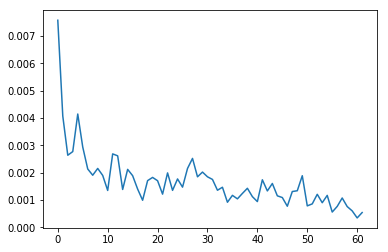

In [251]:
import matplotlib.pyplot as plt

plt.plot(gen_losses)
plt.show()

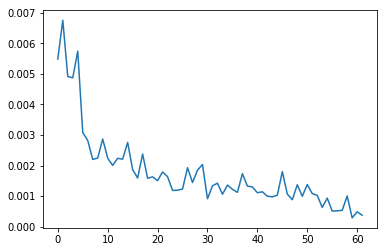

In [253]:
plt.plot(disc_losses)
plt.show()

In [254]:
torch.save(netD_neg.state_dict(), './netD_neg-1m')
torch.save(netG_neg.state_dict(), './netG_neg-1m')

In [255]:
netD_neg.eval()

NetD(
  (t1): Linear(in_features=3706, out_features=1024, bias=True)
  (b1): Linear(in_features=3706, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3706, bias=True)
)

In [256]:
import gc
gc.collect()

5450

In [257]:
# networks
netD_neg_test = NetD(negative_feedback_mask.shape[1]).cuda()
netG_neg_test = NetG(negative_feedback_mask.shape[1]).cuda()

netD_neg_test.eval()
netG_neg_test.eval()

NetG(
  (netGen): Sequential(
    (0): Linear(in_features=3716, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=3706, bias=True)
    (3): Sigmoid()
  )
)

In [258]:
condition, X = batch_generator(X_neg, y_neg, batch_size=128)

X = X.cuda()
condition = condition.cuda()
# real = Variable(X)

noise = torch.randn(128, nz).cuda()
# noise = noise.cuda()
# noisev = Variable(noise)

concated = torch.cat((noise, condition), 1)
fake = netG_neg(X, concated)

In [259]:
fake_test = netG_neg_test(X, concated)

In [260]:
(fake >= 0.5).sum(), ((fake >= 0.5) * (condition==0)).sum(), condition.sum(), X.sum()

(tensor(7139, device='cuda:0'),
 tensor(2873, device='cuda:0'),
 tensor(4424., device='cuda:0'),
 tensor(7427., device='cuda:0'))

In [261]:
(fake_test >= 0.5).sum(), ((fake_test >= 0.5) * (condition==0)).sum(), condition.sum(), X.sum()

(tensor(3689, device='cuda:0'),
 tensor(1453, device='cuda:0'),
 tensor(4424., device='cuda:0'),
 tensor(7427., device='cuda:0'))

In [262]:
(fake >= 0.5).sum(), ((fake >= 0.4) * (condition==0)).sum(), condition.sum(), X.sum()

(tensor(7139, device='cuda:0'),
 tensor(2993, device='cuda:0'),
 tensor(4424., device='cuda:0'),
 tensor(7427., device='cuda:0'))

In [263]:
(fake > 0.5).sum()

tensor(7139, device='cuda:0')

In [264]:
(fake_test > 0.5).sum()

tensor(3689, device='cuda:0')

In [265]:
X.shape

torch.Size([128, 3706])

In [266]:
(fake > 0.48).sum(), ((fake > 0.48) * (condition==0)).sum(), condition.sum()

(tensor(7269, device='cuda:0'),
 tensor(2933, device='cuda:0'),
 tensor(4424., device='cuda:0'))

In [267]:
np.isin(condition.cpu().numpy(), X.cpu().numpy()).all()

True

In [135]:
(fake > 0.4).float().sum()

tensor(23., device='cuda:0')

In [136]:
((fake > 0.4).float() * (condition==0).float() * X).sum(), 

(tensor(9., device='cuda:0'),)

In [268]:
((fake > 0.5).float() * (condition==0).float() * X).sum()/(X * (1 - condition)).sum() # predicted accuraccy

tensor(0.9567, device='cuda:0')

In [269]:
((fake_test > 0.5).float() * (condition==0).float() * X).sum()/(X * (1 - condition)).sum() # predicted accuraccy

tensor(0.4838, device='cuda:0')

In [173]:
((fake > 0.5).float() ).sum()/X.sum() # whole accuraccy

tensor(0.5005, device='cuda:0')

In [174]:
((fake_test > 0.5).float() ).sum()/X.sum() # whole accuraccy

tensor(0.5121, device='cuda:0')

In [142]:
# ((fake > 0.5).float() * (condition==0).float() * X).sum()/(X * (1 - fake)).sum()

tensor(0.4338, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(eval_losses_tr)
plt.show()

In [ ]:
# noise = torch.randn(train.shape[0], nz).to(device)
# noisev = Variable(noise)
# fake = netG_tr(noisev)

In [ ]:
fake.shape

In [ ]:
fake = np.around(fake.detach().cpu().numpy())

In [ ]:
np.unique(fake)

In [ ]:
fake = fake * (fake <= 5).astype(int)

In [ ]:
np.unique(fake)

In [ ]:
get_sparsity(fake)

In [ ]:
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

As we see there is a significant bias towards higher ratings

In [ ]:
# networks
netD_augm = NetD().to(device)
netG_augm = NetG().to(device)
print(netD_augm)
print(netG_augm)
optimizerG = optim.RMSprop(netG_augm.parameters(), lr=lrG)
optimizerD = optim.RMSprop(netD_augm.parameters(), lr=lrD)
one = torch.FloatTensor([1]).to(device)
mone = (-1 * one).to(device)

In [ ]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)
fake = netG_augm(noisev)

In [ ]:
fake = np.around(fake.detach().cpu().numpy())
np.unique(fake)

In [ ]:
# without train
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

In [ ]:
# netD_augm.load_state_dict(torch.load('./netG_augm-1m'))
# netD_augm.load_state_dict(torch.load('./netD_augm-1m'))

In [ ]:
netD_augm.train()
netG_augm.train()
eval_losses_aug = train_GAN(netD_augm, netG_augm, augmented_train)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(eval_losses_aug)
plt.show()

In [ ]:
# netG_tr.eval()
netG_augm.eval()

In [ ]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)
fake = netG_augm(noisev)

In [ ]:
fake = np.around(fake.detach().cpu().numpy())

In [ ]:
np.unique(fake)

In [ ]:
# fake = fake * (fake <= 5).astype(int)

fake = fake.clip(0,5)

In [ ]:
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

In [ ]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)

fake_tr = netG_tr(noisev)
fake_aug = netG_augm(noisev)

In [ ]:
torch.unique(fake_tr.round()), torch.unique(fake_aug.round())

In [ ]:
fake_tr = fake_tr.clamp(0,5).detach().cpu().numpy().round()
fake_aug = fake_aug.clamp(0,5).detach().cpu().numpy().round()

In [ ]:
print(5, (5 == fake_tr).sum(), (5 == (tr + vr)[:fake.shape[0], :]).sum())
print(4, (4 == fake_tr).sum(), (4 == (tr + vr)[:fake.shape[0], :]).sum())
print(3, (3 == fake_tr).sum(), (3 == (tr + vr)[:fake.shape[0], :]).sum())
print(2, (2 == fake_tr).sum(), (2 == (tr + vr)[:fake.shape[0], :]).sum())
print(1, (1 == fake_tr).sum(), (1 == (tr + vr)[:fake.shape[0], :]).sum())
print(0, (0 == fake_tr).sum(), (0 == (tr + vr)[:fake.shape[0], :]).sum())

In [ ]:
print(5, (5 == fake_aug).sum(), (5 == (tr + vr)[:fake.shape[0], :]).sum())
print(4, (4 == fake_aug).sum(), (4 == (tr + vr)[:fake.shape[0], :]).sum())
print(3, (3 == fake_aug).sum(), (3 == (tr + vr)[:fake.shape[0], :]).sum())
print(2, (2 == fake_aug).sum(), (2 == (tr + vr)[:fake.shape[0], :]).sum())
print(1, (1 == fake_aug).sum(), (1 == (tr + vr)[:fake.shape[0], :]).sum())
print(0, (0 == fake_aug).sum(), (0 == (tr + vr)[:fake.shape[0], :]).sum())

In [ ]:
get_sparsity(tr), get_sparsity(fake_tr), get_sparsity(fake_aug)

In [ ]:
# tr_orig, vr_1 = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed,  transpose=False, valfrac=0.1)

In [ ]:
import nbimporter 
import matrix_factorization

In [ ]:
rand_ix = np.random.randint(0, fake.shape[0], 300)

In [ ]:
# adding_fake_autoenc = fake_tr[rand_ix,:]
adding_fake_autoenc_lus_gan = fake_aug[rand_ix,:]

In [ ]:
np.unique(fake_aug)

In [ ]:
np.unique(adding_fake_autoenc_lus_gan[0,:])

In [ ]:
(adding_fake_autoenc == 1).sum()

In [ ]:
(adding_fake_autoenc_lus_gan == 1).sum()

In [ ]:
np.unique(adding_fake_autoenc_lus_gan[0,:])

In [ ]:
adding_fake[0,0:200]

In [ ]:
adding_fake_autoenc_lus_gan[0,0:200]

In [ ]:
tr_auto_enc = np.append(tr, adding_fake_autoenc, axis=0)
tr_auto_enc_plus_gan = np.append(tr, adding_fake_autoenc_lus_gan, axis=0)

In [ ]:
iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

In [ ]:
get_sparsity(augmented_train.cpu().numpy())

In [ ]:
# iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(augmented_train.cpu().numpy(), 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

In [ ]:
# iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([50], vr, learning_rate=0.001)

In [ ]:
# iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(augmented_train.cpu().numpy(), 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([50], vr, learning_rate=0.001)

In [ ]:
tr.shape, augmented_train.cpu().numpy().shape, tr_auto_enc.shape, tr_auto_enc_plus_gan.shape

In [ ]:
get_sparsity(tr_auto_enc), get_sparsity(tr_auto_enc_plus_gan)

In [ ]:
# iter_array = [1, 2, 5, 10, 25, 40]

MF_SGD = matrix_factorization.ExplicitMF(tr_auto_enc, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
# iter_array = [1, 2, 5, 10, 25, 40]

MF_SGD = matrix_factorization.ExplicitMF(tr_auto_enc_plus_gan, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

In [ ]:
get_sparsity(tr_auto_enc_plus_gan), tr_auto_enc_plus_gan.shape

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(tr_auto_enc_plus_gan, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(tr_auto_enc_plus_gan, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(fake_aug, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
augmented_tr = augmented_train.cpu().numpy()

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(augmented_tr, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='als', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [ ]:
MF_SGD = matrix_factorization.ExplicitMF(augmented_tr, 40, learning='als', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 60]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)